# WS 2.4: Atmospheric Pressure

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.4, Time serie analysis. For: December 4, 2024*

In this workshop we will analyze Atmospheric pressure data. The data is a time series of atmospheric pressure measurements over a period of 4 years, with measurements taken every 4 hours. The first column is the time in days, the second column is the atmospheric pressure in hPa.

In this data we will analyze some time series data. We will first fit a functional model to the data in order to stationarize the data. Then we will fit an AR model to the residuals.

We will start by loading the data and plotting it.



## Part 0.1: Load the data and plot it
This week we are using a new library called `statsmodels`. This library is very useful for time series analysis. If you don't have it installed, you can install it by running `!pip install statsmodels` in a code cell. You can also install it by running `pip install statsmodels` in a terminal of your choice (make sure you are in the right environment activated!).

In [1]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import chi2
from scipy.signal import periodogram

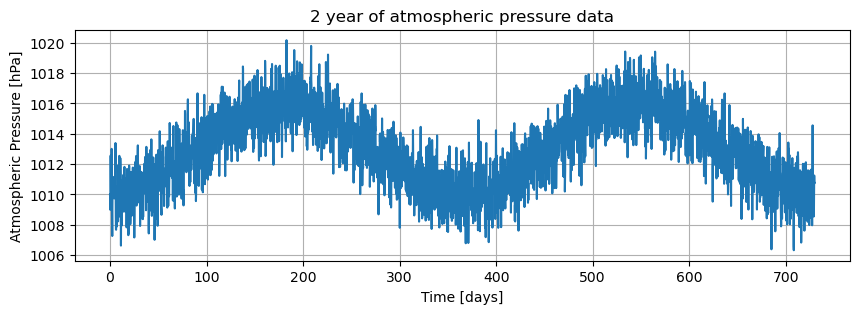

In [ ]:
# Reading the data from the file
data = np.loadtxt('atm_data.txt', delimiter=',')
time = data[:, 0]
data = data[:, 1]

dt = time[1] - time[0]
fs = 1 / dt

# Plotting the data
plt.figure(figsize=(10, 3))
plt.plot(time, data)
plt.xlabel('Time [days]')
plt.ylabel('Atmospheric Pressure [hPa]')
plt.title('2 year of atmospheric pressure data')
plt.grid(True)


## Part 1: Finding the frequency of the seasonal pattern
We clearly see that the data contains a seasonal pattern. We will start by fitting a functional model to the data in order to stationarize the data. To find the frequency of the seasonal pattern we will use the power spectrum of the data.

The time series may be influenced by multiple periodic signals at different frequencies; therefore we will apply a method to find the dominant frequency, and then iteratively remove the corresponding signal from the data.

We will create a function `find_frequency` that will take the data and an $\mathrm{A}$-matrix as input and return the frequency of the most dominant periodic signal.

The function will look like this:

1. Using the $\mathrm{A}$-matrix we will fit a model to the data using the BLUE method. 
2. We will calculate the PSD of the residuals of the model.
3. We will find the frequency of the most dominant periodic signal in the PSD.
4. Optional: we can plot the power spectrum of the data with the highest peak.




We will write functions that return multiple parameters. We will use `_` to indicate that we are not interested in that parameter. For example, if we write `_, b = function(a)`, we are only interested in the second output of the function; The first output is not stored in a variable.


### Part 1.1: write the necessary functions

In [3]:
def fit_model(data, time, A, plot=False):
    '''
    Function to find the Best Linear Unbiased Estimator
    data: input data
    time: time vector
    A: A-matrix to fit the data
    plot: boolean to plot the results or not
    '''

    # Finding the coefficients
    x_hat = np.linalg.solve(A.T @ A, A.T @ data)
    y_hat = A @ x_hat
    e_hat = data - y_hat

    # Plotting the results
    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(211)
        plt.plot(time, data, label='Data')
        plt.plot(time, y_hat, label='Estimated data')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.title('Data vs Estimated data')
        plt.grid(True)
        plt.legend()
        plt.subplot(212)
        plt.plot(time, e_hat, label='Residuals')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.title('Residuals')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

    return x_hat, y_hat, e_hat

def find_frequency(data, time, A, fs, plot=True):
    '''
    Function to find the dominant frequency of the signal
    data: input data
    time: time vector
    A: A-matrix to detrend the data
    fs: sampling frequency
    plot: boolean to plot the psd or not
    '''
    # Detrending the data
    _, _, e_hat= fit_model(data, time, A)

    N = len(data)

    # Finding the dominant frequency in e_hat
    freqs, pxx = periodogram(e_hat, fs=fs, window='boxcar', nfft=N, return_onesided=False, scaling='density')

    # finding the dominant frequency and amplitude
    dominant_frequency, amplitude = freqs[np.argmax(pxx)], np.max(pxx)

    # Plotting the PSD
    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(211)
        plt.plot(e_hat)
        plt.title('Residuals')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.grid(True)
        plt.subplot(212)
        plt.plot(freqs[freqs>0], pxx[freqs>0], label='PSD of residuals')
        plt.xlabel('Frequency')
        plt.ylabel('PSD')
        plt.title('Power Spectral Density')
        plt.grid(True)
        plt.plot(dominant_frequency, amplitude, 'ro', label='Dominant Frequency')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.tight_layout()

    return dominant_frequency


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
How can we use the find_frequency function to find the frequency of all periodic pattern in the data? i.e. how can we iteratively detect the frequencies in the data?
(hint: we should try to remove frequencies from the data once we have detected them)
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
Run the function -> find dominant frequency -> add it to the A matrix -> repeat
</p>
</div>

### Part 1.2
Now we will run `find_frequency` repeatedly to find the frequencies in the data. For the first iteration we will use an $\mathrm{A}$-matrix that will remove a linear trend from the data. When we have found a frequency we will also remove the corresponding signal from the data in the next iteration. 

Dominant Frequency: 1.000 cycle/year


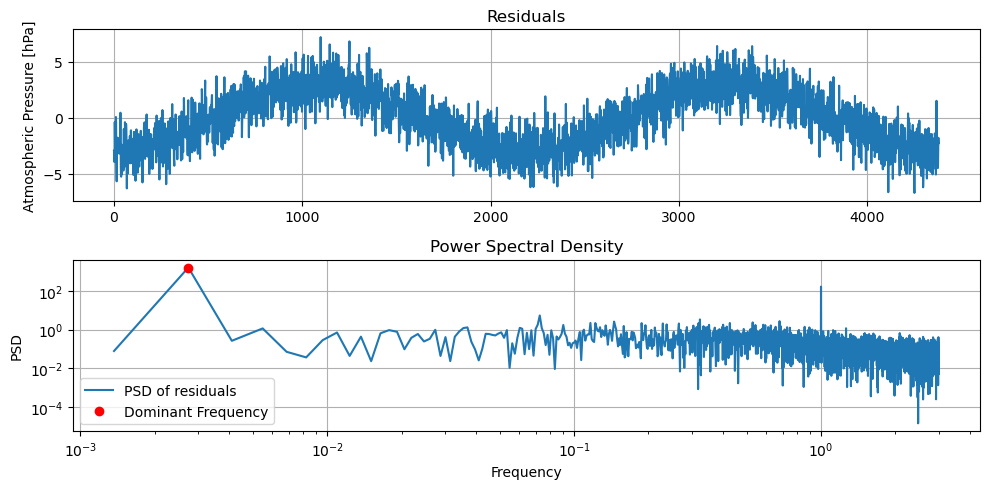

In [4]:
# Find the first dominant frequency

A = np.column_stack((np.ones(len(data)), time))   # A-matrix for linear trend
dom_f = find_frequency(data, time, A, fs)
# print the dominant frequency, do not forget to convert it to useful units
print(f'Dominant Frequency: {dom_f*365:.3f} cycle/year')

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
Looking back at the plot of the original time series, can you see the presence of the signal with this frequency?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
yes there is a clear yearly pattern in the data 
</p>
</div>

Dominant Frequency: 1.000


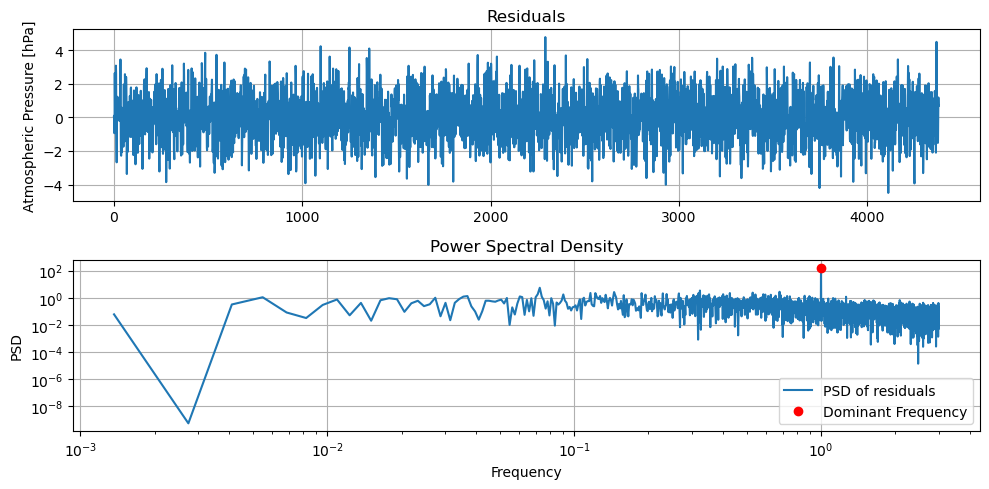

In [5]:
A2 = np.column_stack((A, np.cos(2*np.pi*dom_f*time), np.sin(2*np.pi*dom_f*time)))
dom_f2 = find_frequency(data, time, A2, fs)
print(f'Dominant Frequency: {dom_f2:.3f}')

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
Describe the followed procedure above in your own words to explain how the dominant frequencies were determined. You can try with another iteration to see whether there is  periodic signal at another frequency that should be considered. 

For each step: do you think the corresponding time series (residuals) is stationary? Explain.

How would you decide when to stop?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
- first run: we fit a linear model to the data and find the dominant frequency of 1 cycle per year. PSD of the residuals are not stationary.
- second run: we fit a model with a linear trend and a yearly cycle. We find a dominant frequency of 1 cycle per day. PSD of the residuals are now stationary, so no more runs necessary.
</p>
</div>

Dominant Frequency: 0.073


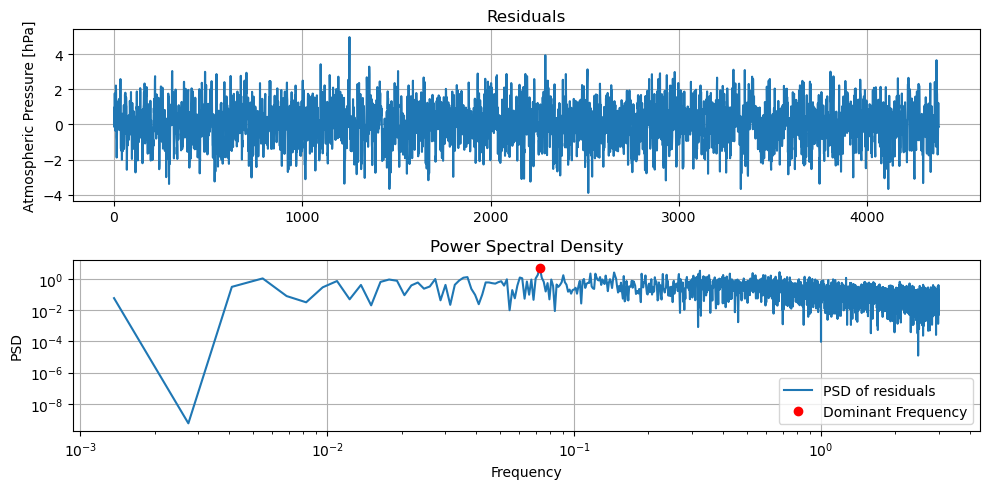

In [6]:
A3 = np.column_stack((A2, np.cos(2*np.pi*dom_f2*time), np.sin(2*np.pi*dom_f2*time)))
dom_f3 = find_frequency(data, time, A3, fs)
print(f'Dominant Frequency: {dom_f3:.3f}')

## Fitting the functional model
In the next cell we will fit the model to generate stationary residuals. Above we have used for each dominant frequency $f_i$ ($i=1,2$) the model:

$$a_i  \cos(2\pi f_i  t) + b_i  \sin(2\pi f_i t)$$ 

However, to report the periodic signals we would like to have the amplitude, phase shift and the frequency of those signals, which can be recovered from:
$$A_i  \cos(2\pi f_i  t + \theta_i)$$
Where the amplitude $A_i = \sqrt{a_i^2 + b_i^2}$ and $\theta_i = \arctan(-b_i/a_i)$

Note: in Section 4.1 book this was shown where the angular frequency $\omega = 2\pi f$ was used.

If you want to compute the $\theta_i$ you can use the `np.arctan2` function. This function is a version of the arctan function that returns the angle in the correct quadrant. Using the `np.arctan` function will not give you the correct angle!


In [7]:
def rewrite_seasonal_comp(ak, bk):
    '''
    Function to rewrite the seasonal component in terms of sin and cos
    ak: seasonal component coefficient for cos
    bk: seasonal component coefficient for sin
    '''
    Ak = np.sqrt(ak**2 + bk**2)
    theta_k = np.arctan2(-bk, ak)
    return Ak, theta_k

# creating the A matrix of the functional model
A = np.column_stack((   np.ones(len(data)), time,
                        np.cos(2*np.pi*dom_f*time), np.sin(2*np.pi*dom_f*time),
                        np.cos(2*np.pi*dom_f2*time), np.sin(2*np.pi*dom_f2*time)))

# Finding the Best Linear Unbiased Estimator
x_hat, y_hat, e_hat = fit_model(data, time, A)

# Extracting the seasonal component coefficients from the estimated parameters
a_i = np.array([x_hat[2], x_hat[4]])
b_i = np.array([x_hat[3], x_hat[5]])
freqs = np.array([dom_f, dom_f2])


print(f'Estimated Parameters:')
for i in range(len(x_hat)):
    print(f'x{i} = {x_hat[i]:.2f}')

print('\nThe seasonal component is rewritten as:')
i = 0
for a, b, f in zip(a_i, b_i, freqs):
    A_i, theta_i = rewrite_seasonal_comp(a, b)
    i = i + 1
    print(f'A_{i} = {A_i:.3f}, theta_{i} = {theta_i:.3f}, f_{i} = {f:.3f}')

Estimated Parameters:
x0 = 1012.92
x1 = 0.00
x2 = -2.99
x3 = 0.04
x4 = -0.07
x5 = -0.96

The seasonal component is rewritten as:
A_1 = 2.990, theta_1 = -3.128, f_1 = 0.003
A_2 = 0.959, theta_2 = 1.642, f_2 = 1.000


## Part 3: Analyzing the residuals
Now that we have our residuals we can fit an AR model to the residuals. We will start by plotting the ACF of the residuals. We will then fit an AR model to the residuals and report the parameters of the AR model..

### Part 3.1: Plot the ACF of the residuals
Use the `plot_acf` function to plot the ACF of the residuals. 

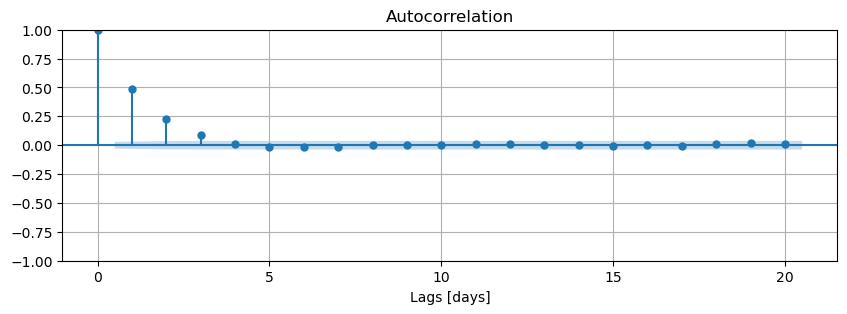

In [8]:
# Lets start with the ACF plot
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(e_hat, ax=ax, lags=20);
ax.set_xlabel('Lags [days]')
ax.grid()



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
What do you conclude from this ACF?
</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
The data is autocreated since lags are significant correlated (up to lag 3) 
</p>
</div>

### Part 3.2: write a function to fit an AR1 model to the residuals
Write a function `AR1` that will take the stationary residuals as input and return the parameters of the AR1 model.
Fit this model to the residuals and report the parameters.

Estimated Parameters:
phi = 0.4908


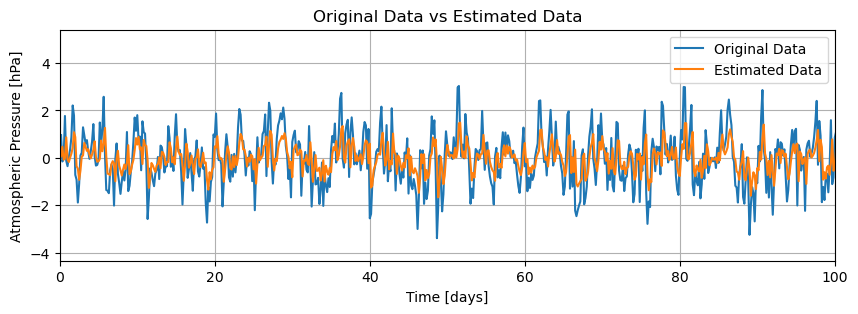

In [ ]:
def AR1(s, time, plot=True):
    '''
    Function to find the AR(1) model of the given data
    s: input data
    return: x_hat, e_hat
    '''
    y = s[1:]
    y_lag_1 = s[:-1]
    A = np.atleast_2d(y_lag_1).T
    x_hat, y_hat, e_hat = fit_model(y, time, A)
    if plot:
        plt.figure(figsize=(10, 3))
        plt.plot(time, s[1:], label='Original Data')
        plt.plot(time, y_hat, label='Estimated Data')
        plt.xlabel('Time [days]')
        plt.ylabel('Atmospheric Pressure [hPa]')
        plt.title('Original Data vs Estimated Data')
        # plt.xlim([0, 100]) # uncomment this line to zoom in, for better visualization
        plt.grid(True)
        plt.legend()

    print(f'Estimated Parameters:')
    print(f'phi = {x_hat[0]:.4f}')

    return x_hat, e_hat

_, e_hat2 = AR1(e_hat, time[1:])


### Part 3.3: Fit an AR1 model to the residuals
Fit an AR1 model to the residuals and report the parameters. 
Finally, we will need to check if AR(1) model is a good fit to the residuals. There are many ways to check whether this is the case. We can use a testing procedure to compare different AR models, an example of this can be found in the book.

However, today we will use a simpler method. If the AR(1) model is a good fit to the residuals, the residuals of the AR(1) model should be white noise. We will plot the ACF of the residuals of the AR(1) model to check if this is the case.

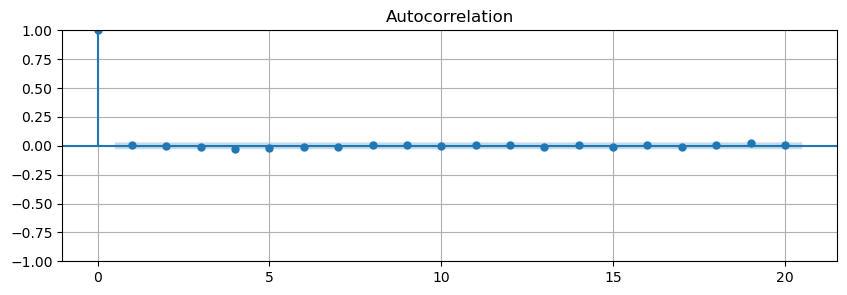

In [10]:
# Lets start with the ACF plot
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf(e_hat2, ax=ax, lags=20);
ax.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

- What do you conclude from this ACF?
  
- Is the AR(1) model a good fit to the residuals?
  
- What would you do if the AR(1) model is not a good fit to the residuals?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
No autocorrelation in the residuals of the AR(1) model, so the AR(1) model is a good fit to the residuals. If the AR(1) model is not a good fit to the residuals we could try a higher order AR model.
</p>
</div>

## Part 4: Report the results
Now that we have found the periodic signals in the data and fitted an AR model to the residuals, we can report the results. By combining including the AR (noise) process, we get residuals that are white noise. When the model hat white noise residuals, we can also report the confidence intervals of the model.

We will use the unbiased estimate of the variance of the residuals to calculate the confidence intervals. The unbiased estimate of the variance is given by:

$$\hat{\sigma}^2 = \frac{1}{n-p} \sum_{t=1}^{n} \hat{e}_t^2$$

Where $n$ is the number of observations and $p$ is the number of parameters in the model.

The covariance matrix of the parameters is given by:

$$\hat{\Sigma} = \hat{\sigma}^2 (\mathbf{A}^T \mathbf{A})^{-1}$$

Where $\mathbf{A}$ is the design matrix of the model.

Estimated Parameters (standard deviation):
x0 = 1012.918		 (0.032)
x1 = 0.000		 (0.000)
x2 = -2.990		 (0.021)
x3 = 0.041		 (0.023)
x4 = -0.068		 (0.021)
x5 = -0.957		 (0.021)
x6 = 0.491		 (0.013)

The seasonal component is rewritten as:
A_1 = 2.990, theta_1 = -3.128, f_1 = 0.003
A_2 = 0.959, theta_2 = 1.642, f_2 = 1.000


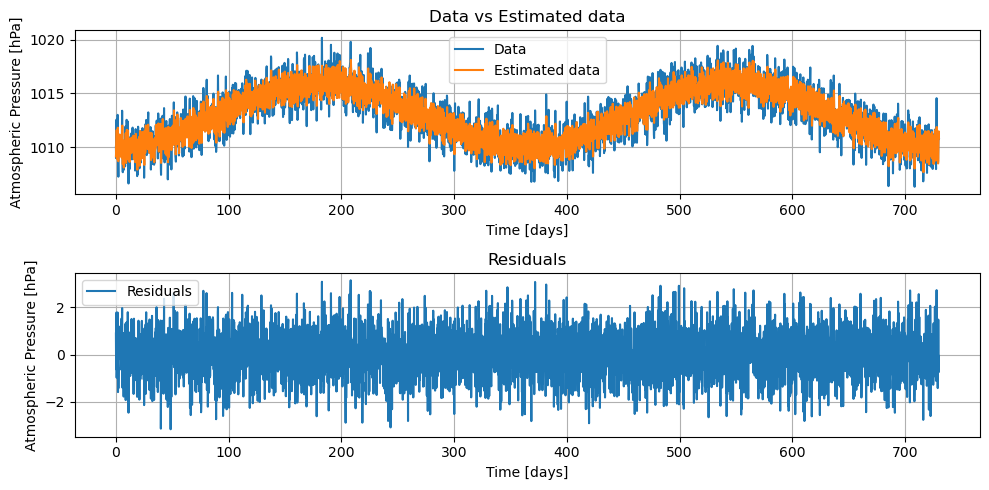

In [11]:
# combine ar1 and seasonal model

A_final = np.column_stack((A[1:,:], e_hat[:-1]))
x_hat, y_hat, e_hat_final = fit_model(data[1:], time[1:], A_final, plot=True)

# compute the standard errors
N = len(data)
p = A_final.shape[1]
sigma2 = np.sum(e_hat_final**2) / (N - p)
Cov = sigma2 * np.linalg.inv(A_final.T @ A_final)
se = np.sqrt(np.diag(Cov))

# Extracting the seasonal component coefficients from the estimated parameters
a_i = np.array([x_hat[2], x_hat[4]])
b_i = np.array([x_hat[3], x_hat[5]])
freqs = np.array([dom_f, dom_f2])

print(f'Estimated Parameters (standard deviation):')
for i in range(len(x_hat)):
    print(f'x{i} = {x_hat[i]:.3f}\t\t ({se[i]:.3f})')

print('\nThe seasonal component is rewritten as:')
i = 0
for a, b, f in zip(a_i, b_i, freqs):
    A_i, theta_i = rewrite_seasonal_comp(a, b)
    i = i + 1
    print(f'A_{i} = {A_i:.3f}, theta_{i} = {theta_i:.3f}, f_{i} = {f:.3f}')


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

- What can you say about the parameters, do the parameters make sense? 

- What time of the day is the pressure highest (on average)?
  
- What has the highest impact on the pressure, the daily or the yearly periodic signal?

</p>
</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
parameters make sense. The average pressure is about 1013 hPa. The pressure is highest at 6:00/7:00. The yearly periodic signal has the highest impact on the pressure.
</p>
</div>